In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

# Define the denoising autoencoder architecture
class TextExtractorAutoencoder(nn.Module):
    def __init__(self, input_channels=3):
        super(DenoisingAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # Reduce spatial dimensions
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  # Further reduce spatial dimensions
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # Upsample
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # Upsample
            
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()  # Output values between 0 and 1
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Custom dataset for loading pairs of noisy and clean images
class DenoisingDataset(Dataset):
    def __init__(self, noisy_dir, clean_dir, transform=None):
        """
        Args:
            noisy_dir (string): Directory with noisy images
            clean_dir (string): Directory with clean images (ground truth)
            transform (callable, optional): Optional transform to be applied
        """
        self.noisy_dir = noisy_dir
        self.clean_dir = clean_dir
        self.transform = transform
        
        self.noisy_images = sorted([f for f in os.listdir(noisy_dir) if f.endswith('.png') or f.endswith('.jpg')])
        self.clean_images = sorted([f for f in os.listdir(clean_dir) if f.endswith('.png') or f.endswith('.jpg')])
        
        # Ensure corresponding pairs
        assert len(self.noisy_images) == len(self.clean_images), "Number of noisy and clean images don't match"
    
    def __len__(self):
        return len(self.noisy_images)
    
    def __getitem__(self, idx):
        noisy_path = os.path.join(self.noisy_dir, self.noisy_images[idx])
        clean_path = os.path.join(self.clean_dir, self.clean_images[idx])
        
        noisy_image = Image.open(noisy_path).convert('RGB')
        clean_image = Image.open(clean_path).convert('RGB')
        
        if self.transform:
            noisy_image = self.transform(noisy_image)
            clean_image = self.transform(clean_image)
        
        return noisy_image, clean_image

# Add Gaussian noise to clean images (for generating noisy images if needed)
def add_gaussian_noise(image, mean=0, std=0.1):
    noise = torch.randn(image.size()) * std + mean
    noisy_image = image + noise
    return torch.clamp(noisy_image, 0., 1.)  # Ensure values stay in [0, 1]

# Training function
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        
        for noisy_imgs, clean_imgs in train_loader:
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
            
            # Forward pass
            outputs = model(noisy_imgs)
            loss = criterion(outputs, clean_imgs)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for noisy_imgs, clean_imgs in val_loader:
                noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
                outputs = model(noisy_imgs)
                loss = criterion(outputs, clean_imgs)
                val_loss += loss.item()
        
        epoch_val_loss = val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')
    
    return model, train_losses, val_losses

# Visualize denoising results
def visualize_results(model, test_loader, num_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    with torch.no_grad():
        for i, (noisy_imgs, clean_imgs) in enumerate(test_loader):
            if i >= num_samples:
                break
                
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
            denoised_imgs = model(noisy_imgs)
            
            # Convert to CPU and numpy for visualization
            noisy_np = noisy_imgs.cpu().numpy().transpose(0, 2, 3, 1)
            clean_np = clean_imgs.cpu().numpy().transpose(0, 2, 3, 1)
            denoised_np = denoised_imgs.cpu().numpy().transpose(0, 2, 3, 1)
            
            # Plot results
            plt.figure(figsize=(15, 5))
            
            for j in range(noisy_imgs.size(0)):
                plt.subplot(3, noisy_imgs.size(0), j + 1)
                plt.imshow(np.clip(noisy_np[j], 0, 1))
                plt.title('Noisy')
                plt.axis('off')
                
                plt.subplot(3, noisy_imgs.size(0), noisy_imgs.size(0) + j + 1)
                plt.imshow(np.clip(denoised_np[j], 0, 1))
                plt.title('Denoised')
                plt.axis('off')
                
                plt.subplot(3, noisy_imgs.size(0), 2*noisy_imgs.size(0) + j + 1)
                plt.imshow(np.clip(clean_np[j], 0, 1))
                plt.title('Ground Truth')
                plt.axis('off')
            
            plt.tight_layout()
            plt.savefig(f'denoising_results_{i}.png')
            plt.show()

# Example usage
def main():
    # Hyperparameters
    batch_size = 16
    num_epochs = 50
    learning_rate = 0.001
    
    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    
    # Load data
    # Replace with your actual directories
    noisy_dir = 'path/to/noisy_images'
    clean_dir = 'path/to/clean_images'
    
    # Create datasets
    full_dataset = DenoisingDataset(noisy_dir=noisy_dir, clean_dir=clean_dir, transform=transform)
    
    # Split into train/val/test
    train_size = int(0.7 * len(full_dataset))
    val_size = int(0.15 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, val_size, test_size]
    )
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True, num_workers=4)
    
    # Initialize model
    model = DenoisingAutoencoder(input_channels=3)
    
    # Train model
    model, train_losses, val_losses = train_model(
        model, train_loader, val_loader, num_epochs=num_epochs, learning_rate=learning_rate
    )
    
    # Save model
    torch.save(model.state_dict(), 'denoising_model.pth')
    
    # Visualize results
    visualize_results(model, test_loader)
    
    # Plot training/validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.savefig('training_losses.png')
    plt.show()

In [ ]:
class Binarize:
  def __init__(self, thr_255):
    self.thr = thr_255

  def __call__(self, x):
    return (x > self.thr).to(x.dtype)

In [5]:
from pathlib import Path

In [10]:
import cv2

In [7]:
labels_path = Path("/Users/volpea/Documents/projects/document-generator-job/data/labels/document_19/")
inputs_path = Path("/Users/volpea/Documents/projects/document-generator-job/data/sample/document_19/")

In [ ]:
image_file.point( lambda p: 255 if p > threshold else 0 )

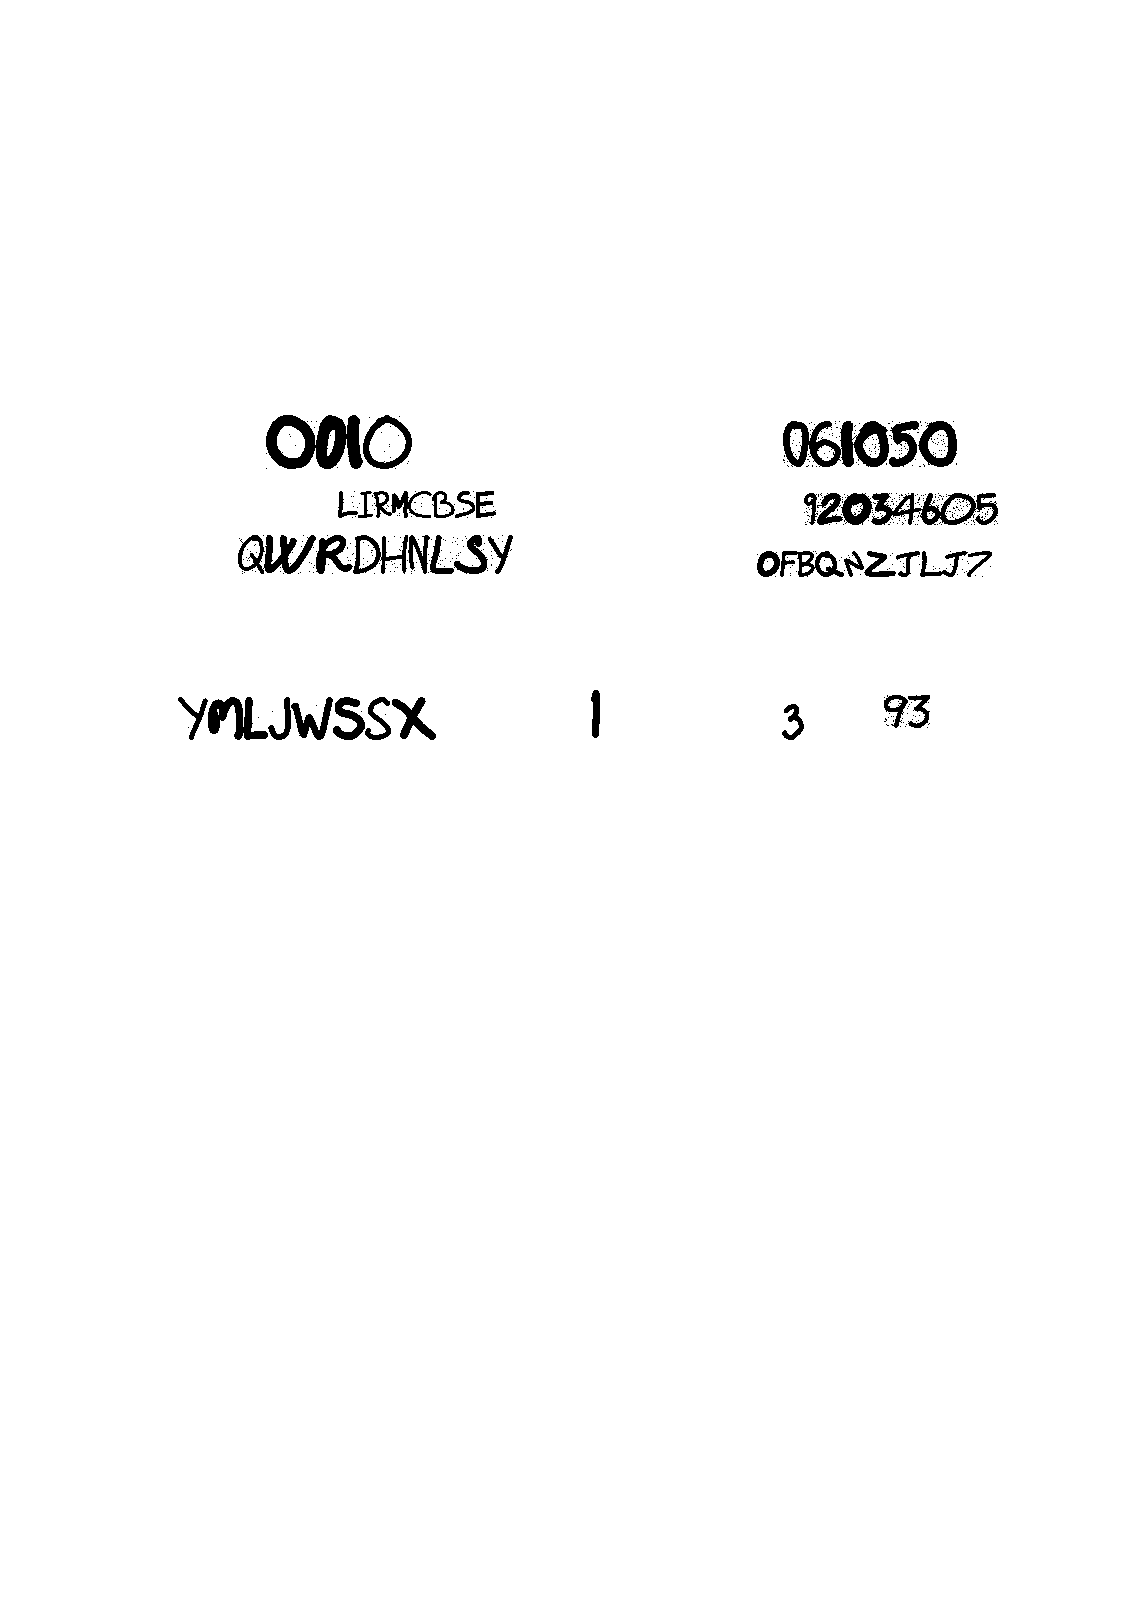

In [18]:
Image.open(labels_path / "text_only_0.png").convert('L').point(lambda p: 255 if p == 255 else 0)